# Inventory & Replenishment Control — Student Notebook (Revised Questions)
Questions now require analytical reasoning, coding awareness, and interpretation as a supply chain analyst.

## STEP 0 — Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(10,4)
df = pd.read_csv('https://raw.githubusercontent.com/saikisri97/17_Hof_Lecture_Code_Pingo/refs/heads/main/Supply_Chain_Analytics/data/inventory_replenishment_data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.head()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/gollapsi/Documents/17_Hof_Lecture_Code_Pingo/Supply_Chain_Analytics/dev/archiv/inventory_replenishment_data.csv'

**Questions:**
- Identify which columns are **state variables** vs **flow variables**.
- Which columns would change if your replenishment policy changes?
- Which columns represent **real-world constraints** rather than decisions?

## STEP 2 — KPI Computation

### 2A — Service Level

In [ ]:
days_in_stock=(df['On_Hand_Inventory']>0).sum()
total_days=len(df)
service_level=days_in_stock/total_days*100
service_level

87.33333333333333

**Questions:**
- If service level improves by 3%, which **lines of code** or parameters upstream are likely to change?
- How would service level react if safety stock is increased? Predict direction, not exact value.

### 2B — Fill Rate

In [ ]:
demand_served=(df['Demand']-df['Backorder_Qty']).clip(lower=0)
total_demand=df['Demand'].sum()
fill_rate=demand_served.sum()/total_demand*100
fill_rate

90.71994715984147

**Questions:**
- Which KPI is more sensitive to `Backorder_Qty`: Service Level or Fill Rate? Why?
- Suggest one code modification that could simulate a ‘partial fulfillment’ scenario. What would you change?

### 2C — Stockout %, Avg Inventory, Turnover

In [ ]:
stockout_days=(df['On_Hand_Inventory']==0).sum()
stockout_pct=stockout_days/total_days*100
avg_inventory=df['On_Hand_Inventory'].mean()
turnover=total_demand/avg_inventory
stockout_pct, avg_inventory, turnover

(12.0, 113.78, 26.612761469502548)

**Questions:**
- If turnover is very high, identify **two coding indicators** that might reveal why.
- How would you rewrite the code to segment turnover by month?
- Which KPI here would a controller (Finance) question first and why?

## STEP 3 — Descriptive Analytics

### 3A — Inventory Over Time

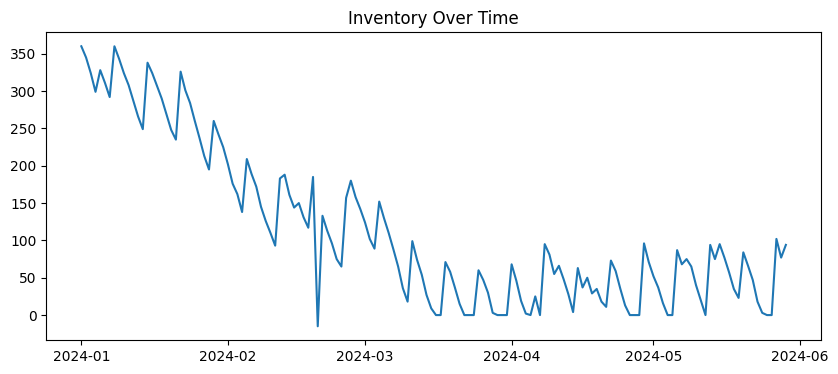

In [ ]:
plt.plot(df['Date'],df['On_Hand_Inventory'])
plt.title('Inventory Over Time');plt.show()

**Questions:**
- From the plot, identify any period where reorder timing was incorrect. Justify using data patterns.
- What modification to the code would add reorder point markers to the plot?
- If you were to identify a systematic delay, which metric in the dataset would you check next?

### 3B — Stockout Timeline

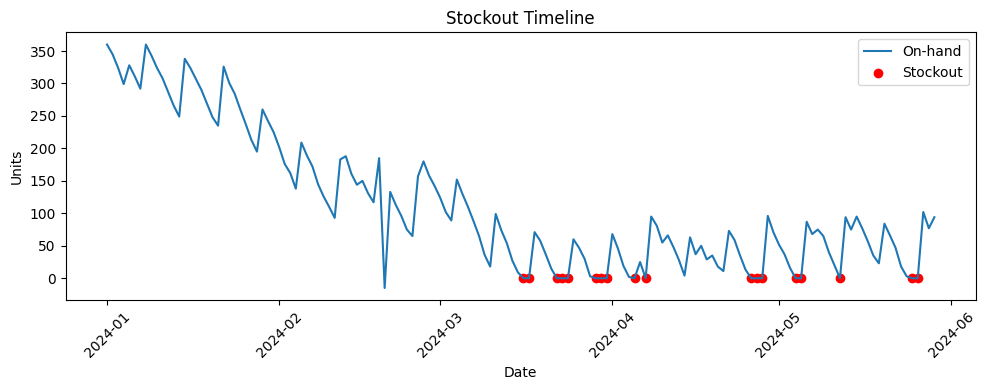

In [ ]:
mask=df['On_Hand_Inventory']==0
plt.plot(df['Date'],df['On_Hand_Inventory'],label='On-hand')
plt.scatter(df.loc[mask,'Date'],df.loc[mask,'On_Hand_Inventory'],color='red',label='Stockout')
plt.title('Stockout Timeline')
plt.xlabel('Date');plt.ylabel('Units')
plt.legend();plt.xticks(rotation=45)
plt.tight_layout();plt.show()

**Questions:**
- Do stockouts align with predictable demand cycles or look random? Explain using evidence.
- Which additional column would you add in the dataset to better diagnose these stockouts?

### 3C — Demand vs Inventory

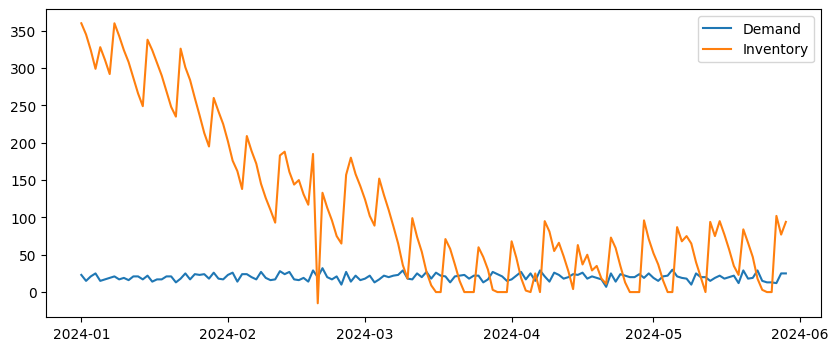

In [ ]:
plt.plot(df['Date'],df['Demand'],label='Demand')
plt.plot(df['Date'],df['On_Hand_Inventory'],label='Inventory')
plt.legend();plt.show()

**Questions:**
- Identify any lag between demand peaks and inventory reactions. How would you detect lag programmatically?
- Suggest a code snippet to add a moving average of demand to stabilize interpretation.

## STEP 4 — Diagnostic Analytics

### 4A — Stockout Day Table

In [ ]:
stockouts=df[df['On_Hand_Inventory']==0]
stockouts[['Date','Demand','Receipt_Qty','Lead_Time_Days']].head()

,Date,Demand,Receipt_Qty,Lead_Time_Days
75,2024-03-16,26,0.0,5
76,2024-03-17,22,0.0,3
81,2024-03-22,23,0.0,5
82,2024-03-23,18,0.0,6
83,2024-03-24,22,0.0,3


**Questions:**
- Determine whether stockouts are demand-driven or supply-driven using 2 indicators in the table.
- Suggest a new derived column that could help classify stockout causes more accurately.

### 4B — Cause Classification

In [ ]:
avg_d=df['Demand'].mean();std_d=df['Demand'].std();avg_L=df['Lead_Time_Days'].mean()
def classify(r):
    ds=r['Demand']>avg_d+std_d
    late=r['Lead_Time_Days']>avg_L
    return 'Both' if ds and late else ('Demand Spike' if ds else 'Late Receipt' if late else 'Normal')
stockouts['Cause']=stockouts.apply(classify,axis=1)
stockouts['Cause'].value_counts()

/var/folders/y2/37476f0n7c793jplk1lghrkjr8cwhw/T/ipykernel_11671/1960189877.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stockouts['Cause']=stockouts.apply(classify,axis=1)


Cause
Normal          7
Late Receipt    7
Both            4
Name: count, dtype: int64

**Questions:**
- If ‘Both’ dominates, which operational teams must jointly intervene?
- How would you evolve the classification logic to include **supplier IDs** or **promotion flags**?

## STEP 5 — Predictive Analytics

### 5A — Days-to-Stockout

In [ ]:
latest=df.iloc[-1];current=latest['On_Hand_Inventory']
recent_avg=df['Demand'].tail(14).mean()
current/recent_avg

4.874074074074074

**Questions:**
- Is the run-rate method stable? What alternative calculation could you propose using rolling windows?
- Suggest one improvement to reduce noise in the prediction.

### 5B — 10-Day Projection

In [ ]:
sim=[];x=current
for i in range(10): x=max(x-recent_avg,0); sim.append(x)
pd.DataFrame({'Day':range(1,11),'Projected_On_Hand':sim})

,Day,Projected_On_Hand
0,1,74.714286
1,2,55.428571
2,3,36.142857
3,4,16.857143
4,5,0.000000
5,6,0.000000
6,7,0.000000
7,8,0.000000
8,9,0.000000
9,10,0.000000


**Questions:**
- On which day do you hit zero? How does this compare to supplier lead time?
- How would you modify code to simulate a demand spike on Day 4?

## STEP 6 — Prescriptive Decision

### 6A — Safety Stock & ROP

In [ ]:
D_avg=df['Demand'].mean();sigma=df['Demand'].std();L=df['Lead_Time_Days'].mean();z=1.65
SS=z*sigma*np.sqrt(L);ROP=D_avg*L+SS;SS,ROP

(16.105652517259628, 107.34938585059295)

**Questions:**
- If SS increases by 20%, which KPI changes first and why?
- Suggest a coding approach to simulate different service level targets by changing `z` dynamically.

### 6B — Order Quantity

In [ ]:
on_hand=latest['On_Hand_Inventory'];on_order=latest['On_Order_Qty'];review=7
current_pos=on_hand+on_order
order_qty=max(D_avg*(L+review)+SS-current_pos,0)
order_qty

0

**Questions:**
- Does the recommended order quantity align with practical truck/pallet constraints?
- If you were to integrate MOQ or EOQ logic, what additional parameters would you include?

### 6C — Managerial Summary

**Task:** Write a 5–7 line summary linking KPIs → causes → risks → recommended replenishment policy.